In [339]:
import numpy as np, matplotlib.pyplot as plt, glob, os, itertools, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import numba as nb, scipy.ndimage
import colorcet

In [2]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnames = [fnameP, fnameA]

In [3]:
RECORDINGS = ['6-23-19-e', '4-5-19-a']

# Find the cluster ID data
arrClustersAll = [[np.load('\\\\?\\Z:\\behavior\\{}\\wavelet\\{}'.format(
    RECORDING, os.path.basename(fnames[fnameIdx]).replace('.npy', '.clusters.npy')))[:,0].astype(int) \
        for RECORDING in RECORDINGS] for fnameIdx in range(len(fnames))]

# Load the position data
fnamePos = [glob.glob('\\\\?\\Z:\\behavior\\{}\\croprot\\*_dlc_abs_filt_interp_mvmt_noborder.npy'.format(
    RECORDING))[0] for RECORDING in RECORDINGS]
xy = [np.mean(np.load(fn)[:, [0,1], 0:2], axis=1) for fn in fnamePos]

In [12]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

In [15]:
POSTERIOR, ANTERIOR = 0, 1

In [26]:
def plotFrame(d, fidx, ax, jointcolor='#000000', segmentcolor='#000000', zorder=10, limbTrace=None):
    # Draw body joints
    for i in [5, 9, 13, 17, 21, 25, 2, 6, 10, 14, 18, 22]: #range(26):
        _x = d[fidx, i,0]
        _y = d[fidx, i,1]
        if not np.isnan(_x) and not np.isnan(_y):
            if jointcolor is not None or limbTrace==i:
                if limbTrace != i:
                    ax.scatter(_y, _x, c=jointcolor, s=8)
                    #ax.text(_x, _y, i, fontsize=12, color=jointcolor)
                else:
                    ax.scatter(_y, _x, c='#ff5555', s=350, marker='*')
                
    def _plot(x, y, c):
        if not np.isnan(x[0]) and \
            not np.isnan(x[1]) and \
            not np.isnan(y[0]) and \
            not np.isnan(y[1]):
            ax.plot(y, x, c, zorder=zorder)

    # Draw body segments
    def _p(i, j): return [
        (d[fidx, i, 0], d[fidx, j, 0]), 
        (d[fidx, i, 1], d[fidx, j, 1]), segmentcolor]

    _plot( *_p(14,18) ); _plot( *_p(18,22) )
    _plot( *_p( 2, 6) ); _plot( *_p( 6,10) )

    #_plot( *_p(15,19) ); _plot( *_p(19,23) )
    #_plot( *_p( 3, 7) ); _plot( *_p( 7,11) )

    #_plot( *_p(16,20) ); _plot( *_p(20,24) )
    #_plot( *_p( 4, 8) ); _plot( *_p( 8,12) )

    _plot( *_p(17,21) ); _plot( *_p(21,25) )
    _plot( *_p( 5, 9) ); _plot( *_p( 9,13) )
    
    # Set bounding box for display
    plt.xlim(-75, 75)
    plt.ylim(-75, 75)

In [61]:
@nb.jit(nopython=True, nogil=True)
def applyRotationAlongAxis(R, X):
    """
    This helper function applies a rotation matrix to every <X, Y> position tuple in a Nx2 matrix.
    Note: Numba JIT leads to a ~6-fold speed improvement.
    """
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j, 0:2] = R[:, :, i] @ X[i, j, 0:2]

def applyRotation(theta, X):
    # Create rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))

    # Perform rotation (Takes on the order of 15-30 seconds for most datasets.)
    applyRotationAlongAxis(R, X)

In [179]:
recID = 1
fnameIdx = ANTERIOR
eventIdx = 10
clusterID = clusterLabels[ANTERIOR]['left-leg'][0]

idxEvent = arrClustersAll[fnameIdx][recID] == clusterID
idxEvent = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(
    idxEvent, iterations=6), iterations=6)
idxEvent = np.argwhere(idxEvent)[eventIdx,0]
idxEvent = np.arange(idxEvent-25, idxEvent+25)

In [509]:
def plotMovement(ax, recID, fnameIdx, clusterID, eventIdx, 
        limbTrace = None, title=None, cmapName='gray', skips=2, alignEachFrame=False):
    limbsToPlot = [5, 9, 13, 17, 21, 25] if fnameIdx == 0 else [2, 6, 10, 14, 18, 22]
    
    idxEvent = arrClustersAll[fnameIdx][recID] == clusterID
    idxEvent = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(
        idxEvent, iterations=6), iterations=6)
    idxEvent = np.argwhere(idxEvent)[eventIdx,0]
    
    xyMov = np.load(fnamePos[recID])[(idxEvent-25):(idxEvent+26),:, 0:2]
    xyMov = xyMov - np.mean(xyMov[:,[0,1],:], axis=1)[:,np.newaxis,:]
    
    # Find orientation of spider
    v = xyMov[:, 0, :] - xyMov[:, 1, :]
    theta = np.arctan2(v[:, 0], v[:, 1])
    if not alignEachFrame:
        theta[:] = theta[24]

    # Orient spider in same direction for interpolation
    applyRotation(theta, xyMov)
    
    for i in range(-24, 25, skips):
        # Decide what to plot
        _xyMov = xyMov.copy()
        for j in range(26):
            if j not in limbsToPlot:
                if i != 0:
                    _xyMov[:,j,:] = np.nan

        # Color
        c = mplcol.rgb2hex(cm.get_cmap(cmapName)(0.5 + i * 0.02))
        jc = c if i == 0 else None
        
        #if i == 0:
        #    c = 'red'
        #    jc = 'red'
        #elif i == 48:
        #    c = 'blue'
        
        # Plot skeleton
        plotFrame(_xyMov, i+25, ax, jointcolor = jc, 
            segmentcolor = c, zorder=(10 if i == 0 else 0) + (100 if (i%8)==0 else 0), 
            limbTrace=limbTrace if i == 0 else None)

    ax.set_axis_off()
    ax.set_xlim(-60, 60)
    ax.set_ylim(-60, 60)
    
    if limbTrace is not None:
        ax.plot(np.linspace(-50, 50, 50), 
                _xyMov[:,limbTrace,0] - np.mean(_xyMov[:,limbTrace,0]) + 50)
        ax.plot(np.linspace(-50, 50, 50), 
                _xyMov[:,limbTrace,1] - np.mean(_xyMov[:,limbTrace,1]) + 40)
        
    if title is not None:
        ax.set_title(title)

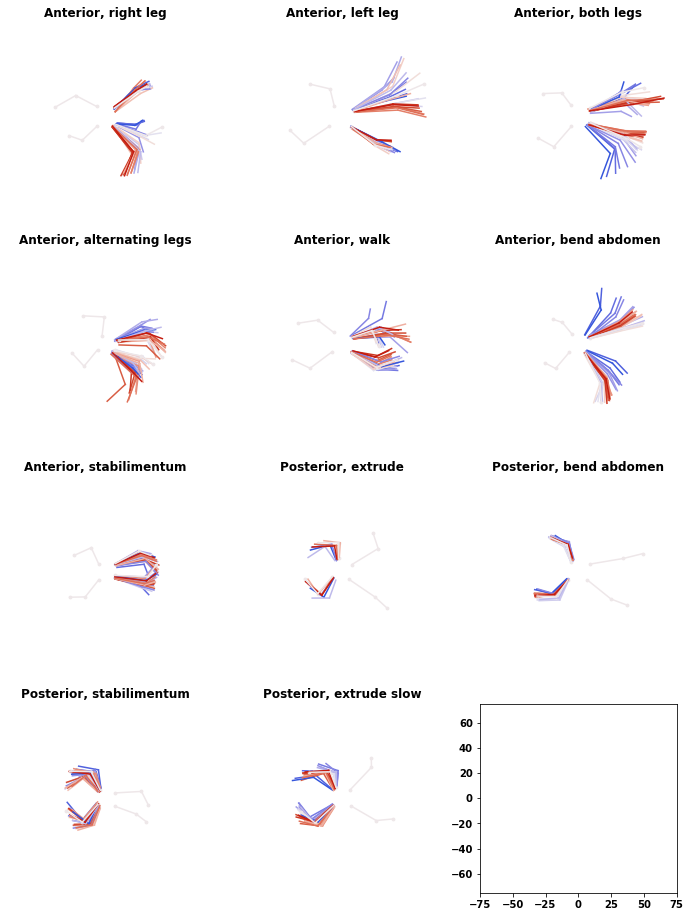

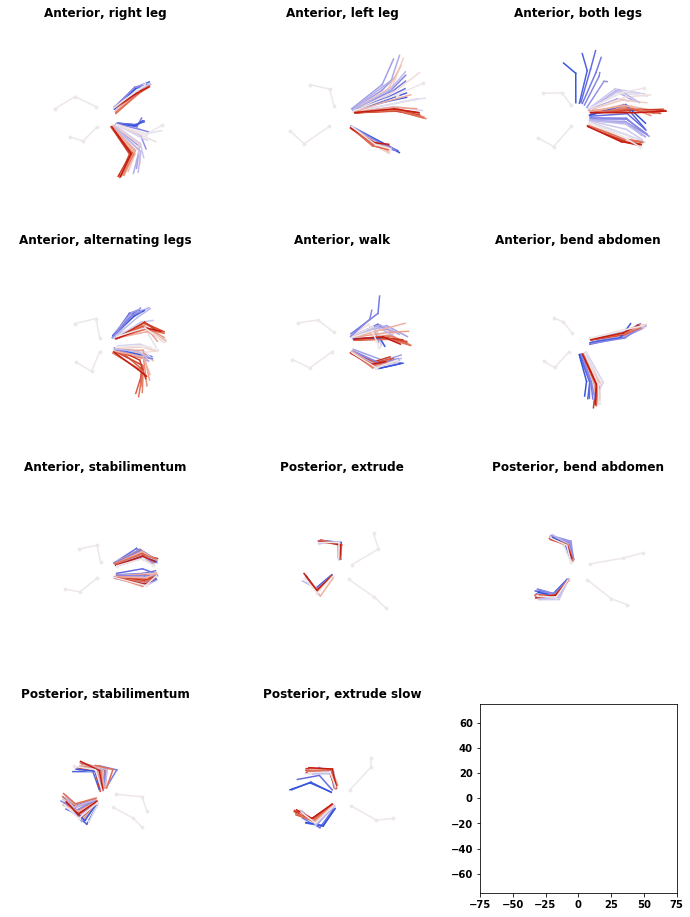

In [510]:
for alignEachFrame in [True, False]:
    fig, ax = plt.subplots(4, 3, figsize=(12, 16))

    cmapName = 'cet_coolwarm'

    plotMovement(ax[0,0], recID = 0, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['right-leg'][4], 
                 eventIdx = 900, limbTrace = None, title='Anterior, right leg', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[0,1], recID = 1, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['left-leg'][7], 
                 eventIdx = 450, limbTrace = None, title='Anterior, left leg', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[0,2], recID = 1, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['both-legs'][3], 
                 eventIdx = 100, limbTrace = None, title='Anterior, both legs', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[1,0], recID = 0, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['one-leg-after-other'][0], 
                 eventIdx = 750, limbTrace = None, title='Anterior, alternating legs', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[1,1], recID = 0, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['walk'][0], 
                 eventIdx = 1500, limbTrace = None, title='Anterior, walk', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[1,2], recID = 0, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['bend-abdomen'][0], 
                 eventIdx = 1000, limbTrace = None, title='Anterior, bend abdomen', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[2,0], recID = 0, fnameIdx = ANTERIOR, 
                 clusterID = clusterLabels[ANTERIOR]['stabilimentum'][1], 
                 eventIdx = 1300, limbTrace = None, title='Anterior, stabilimentum', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[2,1], recID = 0, fnameIdx = POSTERIOR, 
                 clusterID = clusterLabels[POSTERIOR]['extrude'][4], 
                 eventIdx = 100, limbTrace = None, title='Posterior, extrude', 
                 cmapName=cmapName, skips=8, alignEachFrame=alignEachFrame)

    plotMovement(ax[2,2], recID = 0, fnameIdx = POSTERIOR, 
                 clusterID = clusterLabels[POSTERIOR]['bend-abdomen'][2], 
                 eventIdx = 200, limbTrace = None, title='Posterior, bend abdomen', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    plotMovement(ax[3,0], recID = 0, fnameIdx = POSTERIOR, 
                 clusterID = clusterLabels[POSTERIOR]['stabilimentum'][1], 
                 eventIdx = 300, limbTrace = None, title='Posterior, stabilimentum', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    # 1, 1000; 10, 300
    plotMovement(ax[3,1], recID = 0, fnameIdx = POSTERIOR, 
                 clusterID = clusterLabels[POSTERIOR]['extrude-slow'][10], 
                 eventIdx = 300, limbTrace = None, title='Posterior, extrude slow', 
                 cmapName=cmapName, alignEachFrame=alignEachFrame)

    fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_movement_cartoons{}.pdf'.format(
        '_aligneachframe' if alignEachFrame else ''))

C:\Users\acorver\.conda\envs\spider\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Use the colorbar set_ticks() method instead.
  """


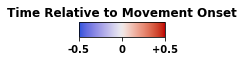

In [528]:
import matplotlib.colorbar as mplcb
fig = plt.figure()
ax = fig.add_axes([0.05, 0.180, 0.2, 0.05])
cb = mplcb.ColorbarBase(ax, orientation='horizontal', cmap=cm.get_cmap('cet_coolwarm'))
cb.ax.set_xticks([0, 0.5, 1.0])
cb.ax.set_xticklabels(['-0.5', '0', '+0.5'])
ax.set_title('Time Relative to Movement Onset')
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_movement_cartoons_colorbar.pdf', bbox_inches='tight')